In [1]:
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
import numpy as np
import tensorflow as tf
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Model
%pip install efficientnet
from efficientnet.tfkeras import EfficientNetB4
from efficientnet.tfkeras import EfficientNetB2
from efficientnet.tfkeras import EfficientNetB0
from tensorflow.keras.applications import ResNet50
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from sklearn.metrics import confusion_matrix
import seaborn as sns
from enum import Enum
import glob
%pip install pillow
from PIL import Image
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

from keras.preprocessing import image
from keras.applications.efficientnet import preprocess_input
from collections import Counter
%pip install shap
import shap


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 10.4 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
params_to_plot = [
    [False, False, 0, 0.0], #0 No balancing, without continuous
    [True, False, 0, 0.0], #No balancing with continuous
    [False, True, 0, 0.0], #2 balancing , without continuous
    [True, True, 0, 0.0], #balancing with continuous
    [False, True, 2000, 0.0], #4 2,000 extra , without continuous
    [True, True, 2000, 0.0], #2,000 extra with continuous
    [False, True, 2000, 0.8], #6 2,000 extra, with 80% reduction, without continuous
    [True, True, 2000, 0.8], #2,000 extra, with 80% reduction, with continuous
    [False, True, 2000, 0.95], #8 2,000 extra, with 95% reduction, without continuous
    [True, True, 2000, 0.95], #2,000 extra, with 95% reduction, with continuous
    [False, True, 2000, 0.65], #10 2,000 extra, with 65% reduction, without continuous
    [True, True, 2000, 0.65], #2,000 extra, with 65% reduction, with continuous
    [False, True, 2000, 0.5], #10 2,000 extra, with 65% reduction, without continuous
    [True, True, 2000, 0.5], #2,000 extra, with 65% reduction, with continuous
]
headers = ["continuous_augmentation", "augment_data", "extra_to_majority", "reduce_malignant_rate"]
df_runs = pd.DataFrame(params_to_plot, columns=headers)
## Place your run in params_to_plot, and then set my_run to the index
my_run = 9
my_row = df_runs.iloc[my_run]

class ExplainType(Enum):
  SHAP=1
  LIME=2
  GRADCAM=3

my_type = ExplainType.SHAP

In [4]:
num_epochs = 24
#agument_data means to add data ahead of time.  This should be off
# if you don't even want to balance the dataset
augment_data = my_row["augment_data"]
#In contrast to the above, augment_model means you want the
# augmentation layers added to the model itself
augment_model = False
#extra_to_majority = 0
extra_to_majority = my_row["extra_to_majority"]
skip_csv=False #should only be true if the data was already generated
skip_eval_ds=True #This just skips the somewhat costly evaluation of the accuaracy
## Should there be continuous augmentation during training or not
continuous_augmentation = my_row["continuous_augmentation"]#False
fake_data = 0
top_dropout_rate = 0.2
artificially_reduce_malignant_rate = my_row["reduce_malignant_rate"]
#artificially_reduce_malignant_rate = 0.0
#if continuous_augmentation:
#  out_folder='b_aug_data_'+str(augment_data)+'_aug_model_'+str(augment_model)+'_extra_'+str(extra_to_majority)+'_malreduction_'+str(artificially_reduce_malignant_rate)
#else:
out_folder='b_aug_data_'+str(augment_data)+'_continuous_'+str(continuous_augmentation)+'_extra_'+str(extra_to_majority)+'_malreduction_'+str(artificially_reduce_malignant_rate)

output_directory = './drive/MyDrive/ML/BreastCancerProject/report/'+out_folder+'/'
ex_dir = "none"
if my_type == ExplainType.SHAP:
  ex_dir = "shap"
elif my_type == ExplainType.LIME:
  ex_dir = "lime"
explain_directory = output_directory+ex_dir +'/'
os.makedirs(explain_directory, exist_ok=True)

class SelectedModel(Enum):
    Eff0 = (224, 224)  # Example image size for EfficientNet 0
    Eff2 = (260, 260)  # Example image size for EfficientNet 2
    Eff4 = (380, 380)  # Example image size for EfficientNet 4
    ResNet50 = (224, 224)  # Example image size for ResNet50

    @property
    def image_size(self):
        return self.value
    def is_eff_family(self):
      return self in (SelectedModel.Eff0, SelectedModel.Eff2, SelectedModel.Eff4)


# Select the model
#my_mod = SelectedModel.ResNet50
my_mod = SelectedModel.Eff2

undersample_test = False


In [5]:
from matplotlib.layout_engine import TightLayoutEngine
# Function to display images in a grid
def display_images_in_grid(images, labels, predictions=None, confidences=None, ncols=4):
  print("Num images: "+str(len(images)))
  nrows = (len(images) + ncols -1) // ncols

  plt.figure(figsize=(15, 10))

  for i in range(len(images)):
    plt.subplot(nrows, ncols, i + 1)
    plt.imshow(cv2.cvtColor(cv2.imread(images[i]), cv2.COLOR_BGR2RGB))  # Read and display the image
    title="True: "+str(labels[i])
    if predictions:
      title += "\nPredicted: "+str(predictions[i])
    if confidences:
      title += "\nConfidence: "+str(confidences[i])

    plt.title(title)
    plt.axis('off')
  plt.tight_layout()
  plt.show()

def convert(image):
  return np.array(image).astype(int)
  #return (image > 0).astype(np.uint8)
def convert2(image):
  #return np.array(image).astype(int)
  return (image > 0).astype(np.uint8)


def predict_and_display_images_in_grid(model, data_gen, num_images_to_display = 4  ):
  #print(data_gen.class_indices)
  class_labels = {value: key for key, value in data_gen.class_indices.items()}
  print(class_labels)
  predictions = []
  ground_truth_labels = []
  # plot a single image
  for x,y in data_gen:
    print("Plotting x with length "+str(len(x)))
    for i in range(len(x)):
      image = convert(x[i])  # Get the ith image from the batch
      print("Shape")
      print(image.shape)
      label_confidence=np.max(y[i])
      label_index = np.argmax(y[i])  # Get the index of the predicted class
      pred= class_labels[np.argmax(model.predict(tf.expand_dims(image, axis=0))[0])]
      predictions.append(pred)
      ground_truth_labels.append(class_labels[label_index])
      #print(y[i])
      #print(len(predictions))
      # Display the image

      plt.imshow(image)
      plt.title(f"Label: {class_labels[label_index]}\nPred: "+str(pred))
      plt.grid(False)
      plt.show()
      plt.hist(image.flatten(), bins=50, alpha=0.5, label='Original', color='blue')
      plt.title('Original Intensity Distribution')
      plt.xlabel('Pixel Intensity')
      plt.ylabel('Frequency')
      plt.legend()
      plt.show()

      if(i >= num_images_to_display):
        break
    break
  print(ground_truth_labels)
  print(predictions)
  ret={}
  ret['groundtruth']=ground_truth_labels
  ret['predictions']=predictions
  return ret
def show_confusion_matrix(truth, pred, title):
  print("Showing Confusion Matrix")
  print(len(truth))
  print(len(pred))
  accuracy = accuracy_score(truth, pred)
  print("Accuracy: {:.2%}".format(accuracy))

  conf_matrix = confusion_matrix(truth, pred)

  # Create a heatmap to visualize the confusion matrix
  plt.figure(figsize=(10, 8))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title(title)
  plt.show()


def plot_sample_from_filenames(df):
  # Randomly select 16 indices from your DataFrame
  sample_indices = random.sample(range(len(df)), 16)

  # Create a subplot with 4 rows and 4 columns to display the images
  plt.figure(figsize=(10, 10))
  for i, idx in enumerate(sample_indices):
    image_path = df['filename'].iloc[idx]
    label = df['class'].iloc[idx]

    ax = plt.subplot(4, 4, i + 1)
    img = plt.imread(image_path)

    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

  plt.show()

def plot_class_counts(df, xname):
  # Create a count plot using Seaborn
  plt.figure(figsize=(8, 6))
  sns.set(style='whitegrid')  # Set the style

  # Create the count plot
  sns.countplot(data=df, x=xname)

  # Set plot labels and title
  plt.xlabel(xname)
  plt.ylabel('Count')
  plt.title('Count of Each Class')

  # Show the plot
  plt.show()


# Define a custom function to filter out file paths containing "mask"
def filter_mask_images(image_paths, labels):
    filtered_paths, filtered_labels = [], []
    for path, label in zip(image_paths, labels):
        if "mask" not in os.path.basename(path):  # Check if "mask" is not in the filename
            filtered_paths.append(path)
            filtered_labels.append(label)
    return np.array(filtered_paths), np.array(filtered_labels)





In [6]:
fake_data = 0
top_dropout_rate = 0.2

# Define the directory where your images are stored
base_directory = './drive/MyDrive/ML/BreastCancerProject/data/Dataset_BUSI_with_GT/'
mask_directory = './drive/MyDrive/ML/BreastCancerProject/data/Dataset_masks/'
saved_model_base = './drive/MyDrive/ML/BreastCancerProject/savedmodels/best_model'
if fake_data == 1:
  base_directory = './drive/MyDrive/ML/BreastCancerProject/data/Fake/'
  mask_directory = './drive/MyDrive/ML/BreastCancerProject/data/Fake_masks/'
  saved_model_base = './drive/MyDrive/ML/BreastCancerProject/savedmodels/fake_best_model'
elif fake_data == 2:
  base_directory = './drive/MyDrive/ML/BreastCancerProject/data/Fake2/'
  mask_directory = './drive/MyDrive/ML/BreastCancerProject/data/Fake2_masks/'
  saved_model_base = './drive/MyDrive/ML/BreastCancerProject/savedmodels/fake2_best_model'


# Define your image dimensions and batch size
image_size = my_mod.image_size
batch_size = 32

# Create an ImageDataGenerator for reading and preprocessing the images
# Normalize the intensitities to [0,1]
image_generator_unfiltered = ImageDataGenerator(rescale=1.0)#1./255)

unfiltered_data_generator = image_generator_unfiltered.flow_from_directory(
    base_directory,
    target_size=image_size,  # Set the target image size
    batch_size=batch_size,
    class_mode='categorical',  # For multiple classes, use 'categorical'
    shuffle=False  # set this to False if you want to preserve the order
)

# Load the image file paths and labels
print(unfiltered_data_generator.classes  )



Found 780 images belonging to 3 classes.
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

In [7]:
class_labels = {value: key for key, value in unfiltered_data_generator.class_indices.items()}


In [8]:
num_classes = len(class_labels)
base_model = None

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(image_size[0], image_size[1]),
  layers.Rescaling(1./255)
])

if True:
  if my_mod is SelectedModel.Eff0:
    base_model= EfficientNetB0(
      include_top=False,
      weights='imagenet',  # You can use 'noisy-student' for different weights
      input_shape=(image_size[0], image_size[1], 3))

  elif my_mod is SelectedModel.Eff2:
    base_model= EfficientNetB2(
      include_top=False,
      weights='imagenet',  # You can use 'noisy-student' for different weights
      input_shape=(image_size[0], image_size[1], 3))

  elif my_mod is SelectedModel.Eff4:
    base_model= EfficientNetB4(
      include_top=False,
      weights='imagenet',  # You can use 'noisy-student' for different weights
      input_shape=(image_size[0], image_size[1], 3))
  elif my_mod is SelectedModel.ResNet50:
      base_model = ResNet50(
      include_top=False,
      weights='imagenet',
      input_shape=(image_size[0], image_size[1], 3))
  else:
    print("Unexpected model type "+str(my_mod))
    exit()

model = None
if augment_model:
  model = tf.keras.Sequential([
    resize_and_rescale,
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomContrast(0.2),
    layers.RandomZoom(0.2),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(top_dropout_rate, name="top_dropout"),
    layers.Dense(num_classes, activation='softmax')
  ])
else:
  model = tf.keras.Sequential([
    resize_and_rescale,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(top_dropout_rate, name="top_dropout"),
    layers.Dense(num_classes, activation='softmax')
  ])

# Specify the input shape for the first layer
model.build(input_shape=(batch_size, image_size[0], image_size[1], 3))


#model = Model(inputs=base_model.input, outputs=x)
model.compile(
  optimizer=tf.keras.optimizers.Adam(lr=0.001),  # You can adjust the learning rate
  loss='categorical_crossentropy',
  metrics=['accuracy']
)
model.summary()







31936256/31936256 [==============================] - 0s 0us/step


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 260, 260, 3)         0         
                                                                 
 efficientnet-b2 (Functiona  (None, 9, 9, 1408)        7768562   
 l)                                                              
                                                                 
 global_average_pooling2d (  (32, 1408)                0         
 GlobalAveragePooling2D)                                         
                                                                 
 batch_normalization (Batch  (32, 1408)                5632      
 Normalization)                                                  
                                                                 
 top_dropout (Dropout)       (32, 1408)                0         
                                                      

In [9]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [10]:

# Define a ModelCheckpoint callback to save the best model during training
best_model = output_directory+'best_model_2000_aug'+str(image_size[0])+'.h5'

model.load_weights(best_model)


In [11]:
def eval_ds(gen, model, num_classes):
  metrics = model.evaluate(gen)
  print(model.metrics_names)
  print(metrics)

print("Unfiltered ")
if not skip_eval_ds:
  eval_ds(unfiltered_data_generator, model,num_classes)


Unfiltered 


{0: 'benign', 1: 'malignant', 2: 'normal'}
Plotting x with length 32
Shape
(260, 260, 3)
1/1 [==============================] - 14s 14s/step


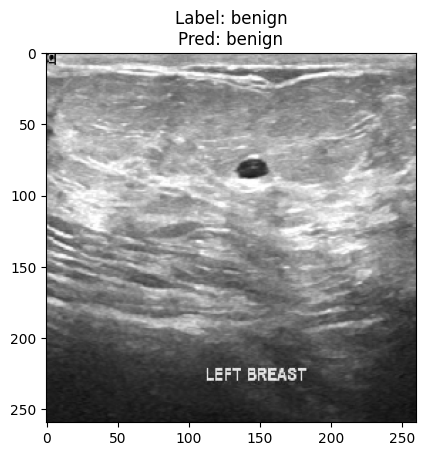

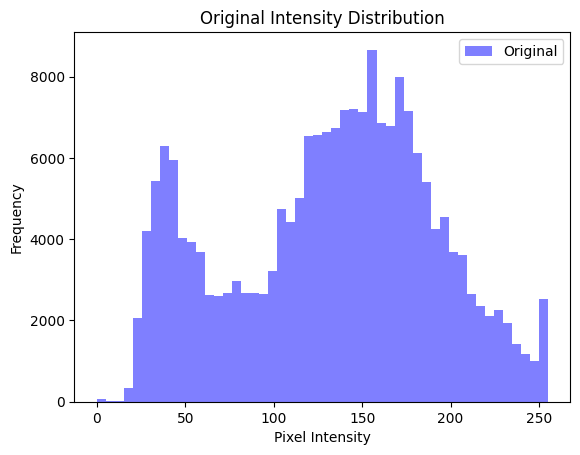

Shape
(260, 260, 3)
1/1 [==============================] - 0s 31ms/step


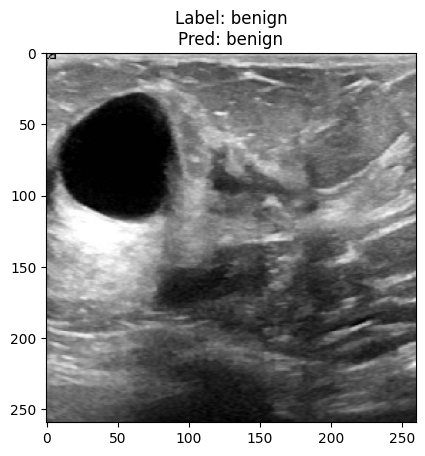

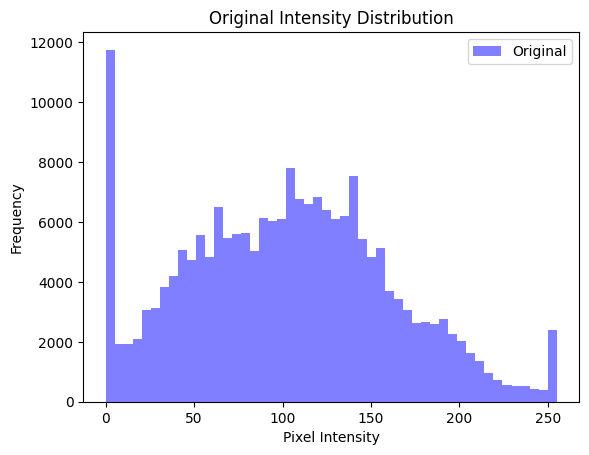

Shape
(260, 260, 3)
1/1 [==============================] - 0s 39ms/step


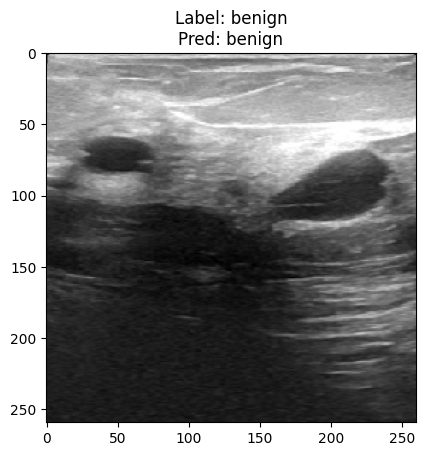

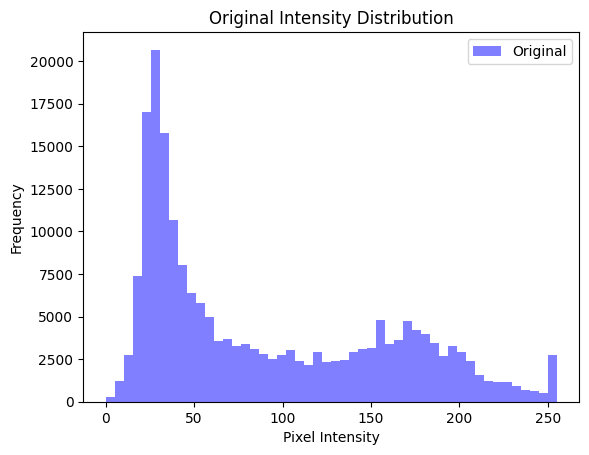

Shape
(260, 260, 3)
1/1 [==============================] - 0s 29ms/step


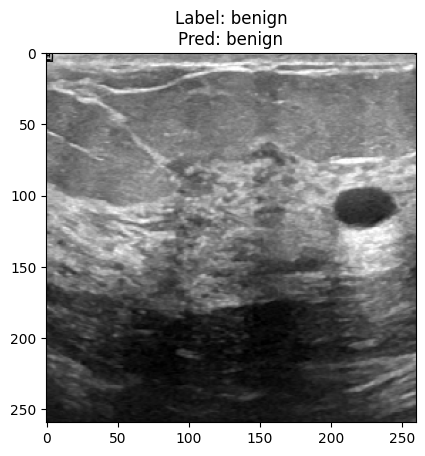

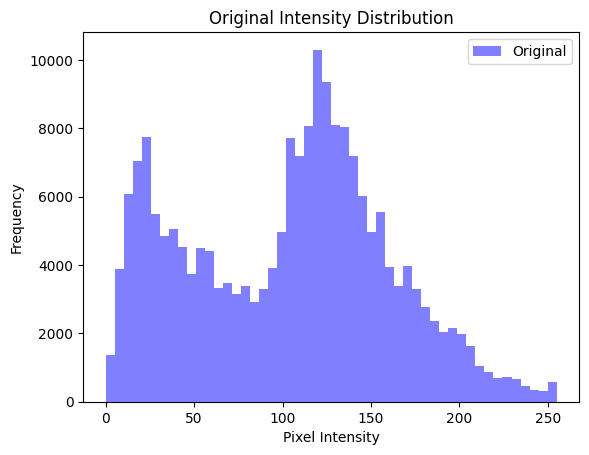

Shape
(260, 260, 3)
1/1 [==============================] - 0s 30ms/step


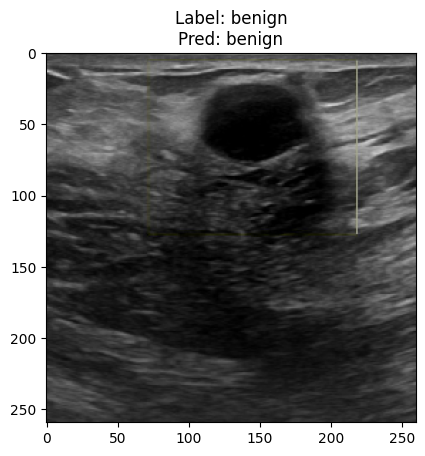

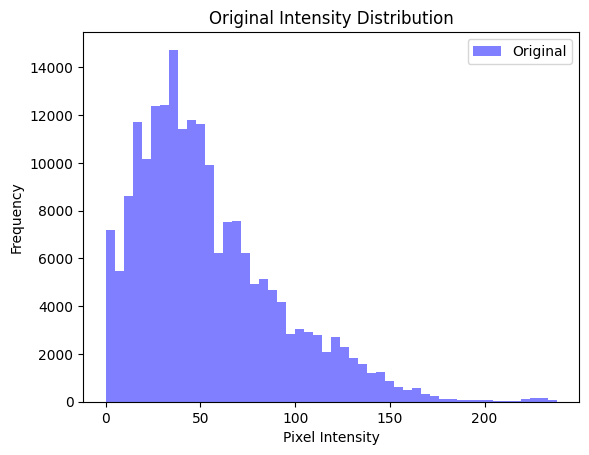

['benign', 'benign', 'benign', 'benign', 'benign']
['benign', 'benign', 'benign', 'benign', 'benign']
5
5


In [12]:
results=predict_and_display_images_in_grid(model, unfiltered_data_generator)
ground_truth_labels=results['groundtruth']
predicted_labels=results['predictions']
print(len(ground_truth_labels))
print(len(predicted_labels))


In [13]:
%pip install lime
from lime import lime_image
import lime
from skimage.segmentation import mark_boundaries
from contextlib import redirect_stdout
explainer_lime = lime_image.LimeImageExplainer()



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=99655d3bfcf032aff452f71de4b0f516d60ed2379af38f9c2ce840935ff7f680
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [14]:

# Create a SHAP explainer for image classification
# define a masker that is used to mask out partitions of the input image.
masker=None
explainer_shap = None


In [15]:
#tf.experimental.numpy.experimental_enable_numpy_behavior()
def summarize_image(image, name, no_op=False):
  if no_op:
    return
  # Calculate the histogram of pixel values
  print(name+" Dimensions:", image.shape)
  min_value = np.min(image)
  max_value = np.max(image)
  print("Minimum Value in "+name+":", min_value)
  print("Maximum Value in "+name+":", max_value)
  num_bins = 20
  hist, bins = np.histogram(image.ravel(), bins=num_bins, range=(min_value, max_value))

  # Create a range of pixel values within the [0, 1] range
  pixel_values = np.linspace(0, 1, num_bins, endpoint=False)

  # Plot the histogram using Matplotlib
  plt.figure(figsize=(8, 6))
  plt.bar(pixel_values, hist, width=1.0 / num_bins, color='b')
  plt.title("Pixel Value Distribution")
  plt.xlabel("Pixel Value")
  plt.ylabel("Frequency")
  plt.xlim([min_value, max_value])
  plt.show()


In [16]:
def summarize_explanation(prediction, truth_label, ex_mask, truth_mask, save_name = None):
  skip_histograms=True

  truth_positive_lower = .2
  truth_positive_upper = 1.0
  summarize_image(ex_mask, "Ex Mask", no_op=skip_histograms)
  summarize_image(truth_mask, "Truth Mask", no_op=skip_histograms)
  # Create binary masks for explanation_positive and truth_positive
  explanation_positive_mask = convert2(ex_mask)#cv2.inRange(ex_mask, explanation_positive_lower, explanation_positive_upper)
  truth_positive_mask = convert2(cv2.inRange(truth_mask, truth_positive_lower, truth_positive_upper))

  summarize_image(explanation_positive_mask, "Ex Positive Mask", no_op=skip_histograms)
  summarize_image(truth_positive_mask, "Truth Positive Mask", no_op=skip_histograms)

  # Use the inverse of the explanation_positive and truth_positive masks for explanation_zero and truth_zero
  explanation_zero_mask =  1-explanation_positive_mask

  truth_zero_mask =  1-truth_positive_mask
  print("explanation_zero Mask Dimensions:", explanation_zero_mask.shape)
  print("truth_zero Mask Dimensions:", truth_zero_mask.shape)
  summarize_image(explanation_zero_mask, "Ex Zero Mask", no_op=skip_histograms)
  summarize_image(truth_zero_mask, "Truth Zero Mask", no_op=skip_histograms)

  # Calculate the intersection area
  explanation_positive_truth_positive_area = np.sum(np.logical_and(explanation_positive_mask, truth_positive_mask))
  explanation_positive_truth_zero_area = np.sum(np.logical_and(explanation_positive_mask, truth_zero_mask))
  explanation_zero_truth_positive_area = np.sum(np.logical_and(explanation_zero_mask, truth_positive_mask))
  explanation_zero_truth_zero_area = np.sum(np.logical_and(explanation_zero_mask, truth_zero_mask))

  # Calculate the percentage of area for each color combination
  truth_pos_total = np.sum(truth_positive_mask)
  truth_neg_total = np.sum(truth_zero_mask)
  if truth_pos_total > 0.0:
    percentage_explanation_positive_truth_positive = (explanation_positive_truth_positive_area / truth_pos_total) * 100
    percentage_explanation_zero_truth_positive = (explanation_zero_truth_positive_area / truth_pos_total) * 100
  else:
    percentage_explanation_positive_truth_positive = 0.0
    percentage_explanation_zero_truth_positive = 0.0
  if truth_neg_total > 0.0:
    percentage_explanation_positive_truth_zero = (explanation_positive_truth_zero_area / truth_neg_total) * 100
    percentage_explanation_zero_truth_zero = (explanation_zero_truth_zero_area / truth_neg_total) * 100
  else:
    percentage_explanation_positive_truth_zero = 0.0
    percentage_explanation_zero_truth_zero = 0.0

  # Print the results
  print("Prediction = "+prediction)
  print("Truth ="+truth_label)
  print("Percentage of truth_positive with explanation_positive: {:.2f}%".format(percentage_explanation_positive_truth_positive))
  print("Percentage of truth_positive with explanation_zero: {:.2f}%".format(percentage_explanation_zero_truth_positive))

  print("Percentage of truth_zero with explanation_positive: {:.2f}%".format(percentage_explanation_positive_truth_zero))

  print("Percentage of truth_zero with explanation_zero: {:.2f}%".format(percentage_explanation_zero_truth_zero))
  fig, axes = plt.subplots(2, 2, figsize=(8, 8))  # You can adjust the figure size
  axes[0,0].imshow(explanation_positive_mask)
  axes[0,0].set_title("explanation_positive Mask")
  axes[0,1].imshow(truth_positive_mask)
  axes[0,1].set_title("truth_positive Mask")
  axes[1,0].imshow(np.logical_and(explanation_positive_mask, truth_positive_mask))
  axes[1,0].set_title("explanation_positive AND truth_positive Mask")
  axes[1,1].imshow(np.logical_and(explanation_zero_mask, truth_positive_mask))
  axes[1,1].set_title("explanation_zero AND truth_positive Mask")
  #explanation_positive Positive Impact towards actual Prediction, explanation_zero Negative Impact towards actual
  plt.tight_layout()
  # Show the 2x2 grid of images
  if save_name:
    plt.savefig(explain_directory+save_name)
  plt.show()
  return [percentage_explanation_positive_truth_positive/100.,percentage_explanation_positive_truth_zero/100. ]

In [17]:
def summarize_explanation_shap(prediction, truth_label, ex_mask, truth_mask, save_name = None):
  skip_histograms=True

  truth_positive_lower = .2
  truth_positive_upper = 1.0
  summarize_image(ex_mask, "Ex Mask", no_op=skip_histograms)
  summarize_image(truth_mask, "Truth Mask", no_op=skip_histograms)
  # Create binary masks for explanation_positive and truth_positive
  explanation_positive_mask = convert2(ex_mask)#cv2.inRange(ex_mask, explanation_positive_lower, explanation_positive_upper)
  truth_positive_mask = convert2(cv2.inRange(truth_mask, truth_positive_lower, truth_positive_upper))

  summarize_image(explanation_positive_mask, "Ex Positive Mask", no_op=skip_histograms)
  summarize_image(truth_positive_mask, "Truth Positive Mask", no_op=skip_histograms)

  # Use the inverse of the explanation_positive and truth_positive masks for explanation_zero and truth_zero
  explanation_zero_mask =  1-explanation_positive_mask

  truth_zero_mask =  1-truth_positive_mask
  print("explanation_zero Mask Dimensions:", explanation_zero_mask.shape)
  print("truth_zero Mask Dimensions:", truth_zero_mask.shape)
  summarize_image(explanation_zero_mask, "Ex Zero Mask", no_op=skip_histograms)
  summarize_image(truth_zero_mask, "Truth Zero Mask", no_op=skip_histograms)

  # Calculate the intersection area
  #explanation_positive_truth_positive_area = np.sum(np.logical_and(explanation_positive_mask, truth_positive_mask))
  #explanation_positive_truth_zero_area = np.sum(np.logical_and(explanation_positive_mask, truth_zero_mask))
  #explanation_zero_truth_positive_area = np.sum(np.logical_and(explanation_zero_mask, truth_positive_mask))
  #explanation_zero_truth_zero_area = np.sum(np.logical_and(explanation_zero_mask, truth_zero_mask))

  # Calculate the percentage of area for each color combination
  #truth_pos_total = np.sum(truth_positive_mask)
  #truth_neg_total = np.sum(truth_zero_mask)
  #if truth_pos_total > 0.0:
  #  percentage_explanation_positive_truth_positive = (explanation_positive_truth_positive_area / truth_pos_total) * 100
  #  percentage_explanation_zero_truth_positive = (explanation_zero_truth_positive_area / truth_pos_total) * 100
  #else:
  #  percentage_explanation_positive_truth_positive = 0.0
  #  percentage_explanation_zero_truth_positive = 0.0
  #if truth_neg_total > 0.0:
  #  percentage_explanation_positive_truth_zero = (explanation_positive_truth_zero_area / truth_neg_total) * 100
  #  percentage_explanation_zero_truth_zero = (explanation_zero_truth_zero_area / truth_neg_total) * 100
  #else:
  #  percentage_explanation_positive_truth_zero = 0.0
  #  percentage_explanation_zero_truth_zero = 0.0

  # Print the results
  print("Prediction = "+prediction)
  print("Truth ="+truth_label)
  #print("Percentage of truth_positive with explanation_positive: {:.2f}%".format(percentage_explanation_positive_truth_positive))
  #print("Percentage of truth_positive with explanation_zero: {:.2f}%".format(percentage_explanation_zero_truth_positive))

  #print("Percentage of truth_zero with explanation_positive: {:.2f}%".format(percentage_explanation_positive_truth_zero))

  #print("Percentage of truth_zero with explanation_zero: {:.2f}%".format(percentage_explanation_zero_truth_zero))
  fig, axes = plt.subplots(2, 2, figsize=(8, 8))  # You can adjust the figure size
  axes[0,0].imshow(explanation_positive_mask)
  axes[0,0].set_title("explanation_positive Mask")
  #axes[0,1].imshow(truth_positive_mask)
  #axes[0,1].set_title("truth_positive Mask")
  #axes[1,0].imshow(np.logical_and(explanation_positive_mask, truth_positive_mask))
  #axes[1,0].set_title("explanation_positive AND truth_positive Mask")
  #axes[1,1].imshow(np.logical_and(explanation_zero_mask, truth_positive_mask))
  #axes[1,1].set_title("explanation_zero AND truth_positive Mask")
  #explanation_positive Positive Impact towards actual Prediction, explanation_zero Negative Impact towards actual
  plt.tight_layout()
  # Show the 2x2 grid of images
  if save_name:
    plt.savefig(explain_directory+save_name)
  plt.show()
  #return [percentage_explanation_positive_truth_positive/100.,percentage_explanation_positive_truth_zero/100. ]

In [18]:


explainer_shap = None
masker = None
def explain_images2(model, data_gen, num_images_to_display = 4, given_type=ExplainType.LIME  ):
  global explainer_shap
  global masker
  #random.seed(42)
  random.seed(44)
  class_labels = {value: key for key, value in data_gen.class_indices.items()}
  sorted_labels = sorted(class_labels.values())
  print(class_labels)
  predictions = []
  ground_truth_labels = []
  # plot a single image
  file_names = data_gen.filenames
  labels = data_gen.labels
  sample_indices = set(random.sample(range(len(file_names)), num_images_to_display))
  #this one is interesting, so add it.
  sample_indices.add(114)
  max_index = max(sample_indices)
  print(sample_indices)
  result_data = {'id': [], 'truth': [], 'pred': [], 'explanation_for_label':[], 'pos_inside_mask': [], 'pos_outside_mask':[]}
  result = pd.DataFrame(result_data)
  outer_counter=-1
  for image_name,y in zip(file_names, labels):
    outer_counter+=1
    #print(outer_counter)
    if not outer_counter in sample_indices:
      continue

    print(outer_counter)

    print("original image = ",image_name)
    image_path = base_directory+image_name
    print("original image = ",image_path)
    tmp_filename=image_name
    if fake_data == 0:
      tmp_filename = tmp_filename[:-4] + "_mask.png"
    else:
      tmp_filename = tmp_filename.rsplit('/', 1)[0] + "/mask.png"
    orig_mask = mask_directory+tmp_filename
    print("mask = ",orig_mask)
    mask_img= mpimg.imread(orig_mask)
    img= mpimg.imread(image_path)

    #summarize_image(img, name="Original", no_op=False)
    #num_channels = img.shape[-1] if len(img.shape) == 3 else 1
    #if num_channels == 1:
    #  print("converting to rbg")
    #  img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    mask_img = cv2.resize(mask_img, image_size, interpolation=cv2.INTER_LINEAR)
    img = cv2.resize(img, image_size, interpolation=cv2.INTER_LINEAR)
    img = (img * 255).astype(int)

    # Create a 2x2 grid of subplots


    #summarize_image(img, name="Not Expanded", no_op=False)
    expanded_image = tf.expand_dims(img, axis=0)
    label_index = y
    ##added mbrewer after first run
    if not np.isscalar(y):
      print("Converting to scalar")
      label_index = np.argmax(y)  # Get the index of the predicted class
    print(expanded_image.shape)
    print(img.shape)
    #summarize_image(expanded_image,name="Expanded", no_op=False)
    txx = model.predict(expanded_image)
    pred= class_labels[np.argmax(txx[0])]

    predictions.append(pred)
    ground_truth_labels.append(class_labels[label_index])


    fig, axes = plt.subplots(1, 2, figsize=(8,4))  # You can adjust the figure size
    axes[0].imshow(img)
    axes[0].set_title("Label: "+class_labels[label_index]+"\nPred: "+str(pred))
    axes[1].imshow(mask_img)
    axes[1].set_title("Mask")
    plt.tight_layout()
    # Show the 2x2 grid of images
    plt.show()
    # Specify the number of superpixels for the explanation
    num_superpixels = 100
    explanation = None
    shap_values = None
    if given_type == ExplainType.SHAP:
      if True:#with open('NUL', 'w') as fnull:
        if True:#with redirect_stdout(fnull):
          np_img = np.array(expanded_image)
          print("Before if")
          if not explainer_shap:
            print("Building the image shape = ", str(img.shape))
            masker = shap.maskers.Image("inpaint_telea", shape=img.shape)
            print("Building the image shape = ", str(expanded_image.shape))
            #masker = shap.maskers.Image("inpaint_telea", (260, 260, 1))#np_img.shape)
            #masker = shap.maskers.Image("inpaint_ns", expanded_image.shape)
            explainer_shap = shap.Explainer(model, masker=masker, algorithm="additive",)
          print("Prediction")
          pred_label = model.predict(expanded_image)
          print(pred_label)
          print(masker)
          shap_values = explainer_shap(np_img)
          print("Values")
          print(shap_values.values.shape)
          print("Base Values")
          print(shap_values.base_values)
          print("Data")
          print(shap_values.data.shape)
          image_from_results = np.squeeze(shap_values.data)
          image1 = np.squeeze(shap_values.values[..., 0])
          image2 = np.squeeze(shap_values.values[..., 1])
          image3 = np.squeeze(shap_values.values[..., 2])

          image1 = np.where(image1 > 0, 1.0, 0.0)
          image2 = np.where(image2 > 0, 1.0, 0.0)
          image3 = np.where(image3 > 0, 1.0, 0.0)

          #image1 = np.any(image1 > 0, axis=(-1, -2, -3)).astype(float)
          #image2 = np.any(image2 > 0, axis=(-1, -2, -3)).astype(float)
          #image3 = np.any(image3 > 0, axis=(-1, -2, -3)).astype(float)
          fig, axes = plt.subplots(2, 2, figsize=(8,8))  # You can adjust the figure size
          axes[0,0].imshow(img)
          axes[0,0].set_title("Label: "+class_labels[label_index]+"\nPred: "+str(pred))
          axes[0,1].imshow(image1)
          axes[0,1].set_title("SHAP explanation 1")
          axes[1,0].imshow(image2)
          axes[1,0].set_title("SHAP explanation 2")
          axes[1,1].imshow(image3)
          axes[1,1].set_title("SHAP explanation 3")
          plt.tight_layout()
          # Show the 2x2 grid of images
          plt.show()
          #summarize_explanation_shap(pred_label, model.predict(expanded_image), image1, mask_img)

          #pos_inside_mask, pos_outside_mask = summarize_explanation_shap(pred_label, model.predict(expanded_image), result_data, mask_img)
          shap.image_plot(shap_values, np_img, labels = class_labels)
          #print(type(shap_values))
          #break
    elif given_type == ExplainType.LIME:
      with open('NUL', 'w') as fnull:
        with redirect_stdout(fnull):
          explanation = explainer_lime.explain_instance(img, model.predict, top_labels=3, num_features=num_superpixels)
          for l in explanation.top_labels:
            print("Exploring Explanations for label "+class_labels[l])
            ex_image, ex_mask = explanation.get_image_and_mask(l, positive_only=True, num_features=num_superpixels, hide_rest=False)

            # Visualize the image with the explanation mask
            #axes[1,0].imshow(ex_image)
            #axes[1,0].imshow(ex_mask, alpha=0.5)
            #axes[1,0].set_title("Image with Explanation\nOverlayed")
            #axes[1,1].imshow(ex_mask, cmap='jet')
            #axes[1,1].imshow(mask_img, alpha=0.5)
            #axes[1,1].set_title("Explanation with Truth\nMask Overlayed")
            pos_inside_mask, pos_outside_mask = summarize_explanation(pred, class_labels[label_index], ex_mask, mask_img)
            row = {'id': outer_counter, 'truth': class_labels[label_index], 'pred': pred, 'explanation_for_label':class_labels[l], 'pos_inside_mask': pos_inside_mask, 'pos_outside_mask':pos_outside_mask}
            print(row)
            result = result.append(row, ignore_index=True)
            #break

    else:
      print("unexpected type"+str(given_type))
      exit()

  return result


{0: 'benign', 1: 'malignant', 2: 'normal'}
{387, 388, 9, 649, 526, 532, 29, 160, 418, 296, 554, 180, 310, 705, 582, 710, 718, 230, 102, 114, 119}
9
original image =  benign/benign (107).png
original image =  ./drive/MyDrive/ML/BreastCancerProject/data/Dataset_BUSI_with_GT/benign/benign (107).png
mask =  ./drive/MyDrive/ML/BreastCancerProject/data/Dataset_masks/benign/benign (107)_mask.png
(1, 260, 260, 3)
(260, 260, 3)
1/1 [==============================] - 0s 63ms/step


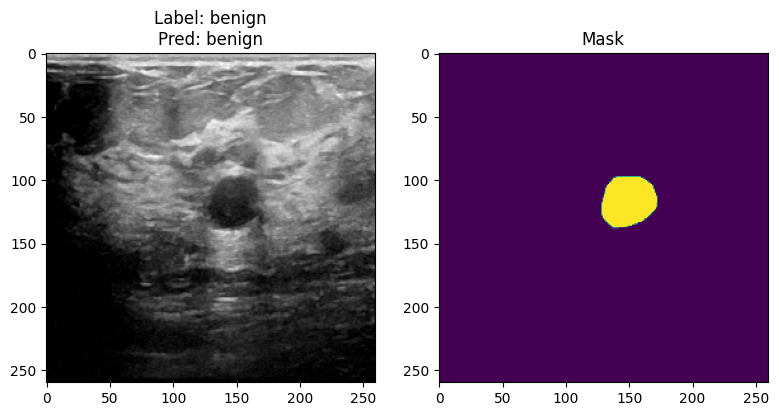

Before if
Building the image shape =  (260, 260, 3)
Building the image shape =  (1, 260, 260, 3)


AssertionError: ignored

In [19]:
if not skip_csv:
  result = explain_images2(model, unfiltered_data_generator, num_images_to_display=20, given_type=my_type)
  print(result.head())

In [ ]:

csv = explain_directory+"lime_output.csv"

if not skip_csv:
  #pd.set_option('display.max_rows', 63)
  result.head()
  result.to_csv(csv)

In [ ]:
df = pd.read_csv(csv)

df['truth_pred_explanation'] = df['truth'].astype(str) + "_" + df['pred'].astype(str) + "_" + df['explanation_for_label'].astype(str)



In [ ]:

# Add a column to identify if truth equals explanation_for_label
df['same_label'] = df['truth'] == df['explanation_for_label']

# Create a figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot for cases where truth equals explanation_for_label
ax = sns.scatterplot(x="pos_inside_mask", y="pos_outside_mask", data=df[df['same_label']], hue="truth_pred_explanation", ax=axes[0])

ax.set_title("Truth = Explanation")
ax.set_xlabel("pos_inside_mask")
ax.set_ylabel("pos_outside_mask")
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.legend(title="Truth_Pred_Explanation", bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_aspect('equal')

# Plot for cases where truth is different from explanation_for_label
ax = sns.scatterplot(x="pos_inside_mask", y="pos_outside_mask", data=df[~df['same_label']], hue="truth_pred_explanation", ax=axes[1])

ax.set_title("Truth ≠ Explanation")
ax.set_xlabel("pos_inside_mask")
ax.set_ylabel("pos_outside_mask")
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.legend(title="Truth_Pred_Explanation", bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_aspect('equal')

# Adjust the layout
plt.tight_layout()

plt.savefig(explain_directory+'truth_explanations.png')
# Show the plots
plt.show()



In [ ]:

# Add a column to identify if truth equals explanation_for_label
df['same_label3'] = (df['truth'] == df['explanation_for_label']) & (df['truth'] == df['pred'])

# Create a figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot for cases where truth equals explanation_for_label
ax = sns.scatterplot(x="pos_inside_mask", y="pos_outside_mask", data=df[df['same_label3']], hue="truth_pred_explanation", ax=axes[0])

ax.set_title("Truth = Explanation")
ax.set_xlabel("pos_inside_mask")
ax.set_ylabel("pos_outside_mask")
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.legend(title="Truth_Pred_Explanation", bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_aspect('equal')

# Plot for cases where truth is different from explanation_for_label
ax = sns.scatterplot(x="pos_inside_mask", y="pos_outside_mask", data=df[~df['same_label3']], hue="truth_pred_explanation", ax=axes[1])

ax.set_title("Truth ≠ Explanation")
ax.set_xlabel("pos_inside_mask")
ax.set_ylabel("pos_outside_mask")
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.legend(title="Truth_Pred_Explanation", bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_aspect('equal')

# Adjust the layout
plt.tight_layout()
plt.savefig(explain_directory+'truth_equal_explanations_and_not.png')

# Show the plots
plt.show()



In [ ]:
grouped = df.groupby('truth')
explicit = ["benign", "malignant", "normal"]
# Define the unique 'pred' and 'explanation_for_label' values
unique_pred = df['pred'].unique()
unique_explanation = df['explanation_for_label'].unique()

# Create a grid of scatter plots

for i, (truth, group) in enumerate(grouped):
  print('Truth: '+truth)
  if len(grouped) < 1:
    print("No values of class Truth = "+truth)
    continue
  fig, axes = plt.subplots(len(explicit), len(explicit), figsize=(12, 8))
  for j, pred in enumerate(explicit):
    for k, explanation in enumerate(explicit):
      ax = axes[j, k]  # Access the appropriate subplot

      # Filter the data for the current combination of 'truth', 'pred', and 'explanation_for_label'
      subset = group[(group['pred'] == pred) & (group['explanation_for_label'] == explanation)]
      ax.set_xlim(0, 1)
      ax.set_ylim(0, 1)
      # Set the aspect ratio to 'equal' to make the plot square
      ax.set_aspect('equal')

      # Create a scatter plot for the filtered data
      sns.scatterplot(x='pos_inside_mask', y='pos_outside_mask', data=subset, ax=ax)

      # Set the title for the scatter plot
      ax.set_title(f'Pred: {pred}, Explanation: {explanation}')

  # Adjust spacing between subplots
  plt.tight_layout()
  # Show the plots
  fig.savefig(explain_directory+truth+'_truth_explanations.png')
  plt.show()
